In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

import librosa
import librosa.display

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


***Unzip the recordings.zip folder***

In [3]:
!unzip /content/drive/MyDrive/spoken_digit/recordings.zip

Archive:  /content/drive/MyDrive/spoken_digit/recordings.zip
   creating: recordings/
  inflating: recordings/0_jackson_0.wav  
  inflating: recordings/0_jackson_1.wav  
  inflating: recordings/0_jackson_10.wav  
  inflating: recordings/0_jackson_11.wav  
  inflating: recordings/0_jackson_12.wav  
  inflating: recordings/0_jackson_13.wav  
  inflating: recordings/0_jackson_14.wav  
  inflating: recordings/0_jackson_15.wav  
  inflating: recordings/0_jackson_16.wav  
  inflating: recordings/0_jackson_17.wav  
  inflating: recordings/0_jackson_18.wav  
  inflating: recordings/0_jackson_19.wav  
  inflating: recordings/0_jackson_2.wav  
  inflating: recordings/0_jackson_20.wav  
  inflating: recordings/0_jackson_21.wav  
  inflating: recordings/0_jackson_22.wav  
  inflating: recordings/0_jackson_23.wav  
  inflating: recordings/0_jackson_24.wav  
  inflating: recordings/0_jackson_25.wav  
  inflating: recordings/0_jackson_26.wav  
  inflating: recordings/0_jackson_27.wav  
  inflating: r

In [ ]:
# Read the all file names in the recordings folder given by us
# (If you get entire path, it is very useful in future)
# Save those files names as list in "all_files"

In [4]:
# https://thispointer.com/python-how-to-get-the-list-of-all-files-in-a-zip-archive/

from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/spoken_digit/recordings.zip', 'r') as zipObj:
   # Get list of files names in zip
   listOfFiles = zipObj.namelist()
   # Iterate over the list of file names in given list & print them
   for elem in listOfFiles:
       elem

all_files = os.listdir('/content/recordings')
# len(all_files)

##### Grader function 1 

In [5]:
def grader_files():
    temp = len(all_files) == 2000
    temp1 = all([x[-3:] == "wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

### Creating dataframe

In [6]:
# Create a dataframe(name = df_audio) with two columns(path, label).   
# You can get the label from the first letter of name.  
# Eg: 0_jackson_0 --> 0  
#     0_jackson_43 --> 0

df_audio = pd.DataFrame()

df_audio['path'] = ['recordings/' + ele for ele in all_files]
df_audio['label'] = [ele.split('_')[0] for ele in all_files]

In [7]:
# Check whether the dataset is balanced or not 

df_audio['label'].sort_values().value_counts()

0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: label, dtype: int64

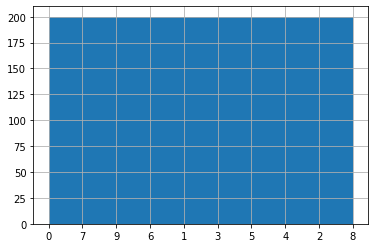

In [8]:
values = df_audio['label']
  
# Visualizing the dataset
hist = values.hist(bins=10)

***It is a balanced dataset.***

In [9]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


##### Grader function 2

In [10]:
def grader_df():
    flag_shape = df_audio.shape == (2000,2)
    flag_columns = all(df_audio.columns == ['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values) == 10
    flag_label2 = all([i == 200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [11]:
#don't change the random state
df_audio = shuffle(df_audio, random_state = 33)

### Train and Validation split

In [12]:
y = df_audio['label']
X = df_audio.drop('label', axis = 1)

In [13]:
# Split the data into train and validation and save in X_train, X_test, y_train, y_test
# use stratify sampling
# use random state of 45
# use test size of 30%

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df_audio['label'], test_size = 0.3, random_state = 45)

print("Train Data:", X_train.shape, y_train.shape)
print("Test Data:", X_test.shape, y_test.shape)

Train Data: (1400, 1) (1400,)
Test Data: (600, 1) (600,)


##### Grader function 3

In [14]:
def grader_split():

    flag_len = (len(X_train) == 1400) and (len(X_test) == 600) and (len(y_train) == 1400) and (len(y_test) == 600)
    
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain) == 10) and (all([i == 140 for i in values_ytrain]))
    
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest) == 10) and (all([i == 60 for i in values_ytest]))
    
    final_flag = flag_len and flag_ytrain and flag_ytest

    return final_flag

grader_split()

True

### Preprocessing

All files are in the "WAV" format. We will read those raw data files using the librosa.

Whenever we read audio signals, we get 2 channels - Mono Channel & Stereo Channel. 

Librosa is commonly used for audio signal processing. 

Why is Librosa used?

- It helps in converging the signals. It converts any audio data into 1 channel i.e. Mono Channel. In Mono Channel, there will be only 1 signal so it returns a 1-D signal. 

- It makes sure that an audio signal will be normalized between [-1, 1].

- sample_rate specifies that a particular audio is saved in a specific frequency (kHz). By default it converts the sample_rate to 22 kHz. 

In [15]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr = 22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [16]:
# Use load_wav function that was written above to get every wave. 
# Save it in X_train_processed and X_test_processed
# X_train_processed / X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train / y_train

samples_train, samples_test, durations_train, durations_test = [],[],[],[]

for ele in X_train['path'].values:
    samples, duration = load_wav(ele)
    samples_train.append(samples)
    durations_train.append(duration)

for ele in X_test['path'].values:
    samples, duration = load_wav(ele)
    samples_test.append(samples)
    durations_test.append(duration)

X_train_processed = pd.DataFrame({'raw_data' : samples_train, 'duration' : durations_train})
X_test_processed = pd.DataFrame({'raw_data' : samples_test, 'duration' : durations_test})

###### How does the dataset look after preprocessing?

In [17]:
X_train_processed.head()

,raw_data,duration
0,"[0.00043474816, 0.00021784598, -4.2759533e-05,...",0.449887
1,"[7.52339e-05, 0.0001356962, 0.00018862588, 0.0...",0.280635
2,"[0.0012452141, 0.00020537808, -0.00063528266, ...",0.453515
3,"[-0.0071221, -0.007959516, -0.008300923, -0.00...",0.356780
4,"[0.000505402, 0.00055196765, 0.00053555705, 0....",0.399909


In [18]:
X_test_processed.head()

,raw_data,duration
0,"[-0.010753613, -0.0025474587, 0.006818897, 0.0...",0.569751
1,"[-0.000121868594, -8.978564e-05, 5.733162e-05,...",0.267392
2,"[3.8347953e-06, -0.0029964468, -0.0062336717, ...",0.196009
3,"[-0.00037120818, -0.000498111, -0.0005147038, ...",0.220408
4,"[-0.009277378, -0.014647031, -0.015955066, -0....",0.492653


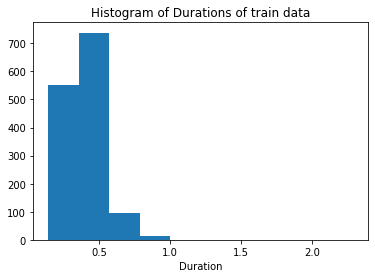

In [19]:
# Plot the histogram of the duration for train

plt.hist(X_train_processed.duration)
plt.xlabel('Duration')
plt.title('Histogram of Durations of train data')
plt.show()

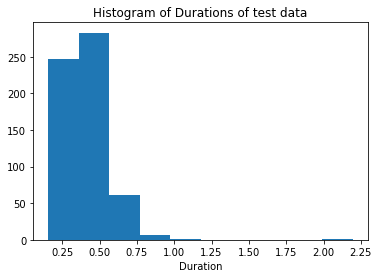

In [20]:
# Plot the histogram of the duration for test

plt.hist(X_test_processed.duration)
plt.xlabel('Duration')
plt.title('Histogram of Durations of test data')
plt.show()

In [21]:
# Print 0-100 percentile values with step size of 10 for train data duration. 

for i in range(0, 101, 10):
    p = np.percentile(X_train_processed.duration.values, i)
    print(str(i)+"th Percentile: "+ str(p))

0th Percentile: 0.1435374149659864
10th Percentile: 0.25955102040816325
20th Percentile: 0.30201360544217687
30th Percentile: 0.3347437641723356
40th Percentile: 0.35908390022675735
50th Percentile: 0.39120181405895693
60th Percentile: 0.4180045351473923
70th Percentile: 0.4450748299319728
80th Percentile: 0.48175963718820863
90th Percentile: 0.5414058956916101
100th Percentile: 2.282766439909297


In [22]:
# Print 90-100 percentile values with step size of 1. 

for i in range(90, 101, 1):
    p = np.percentile(X_train_processed.duration.values, i)
    print(str(i)+"th Percentile: "+ str(p))

90th Percentile: 0.5414058956916101
91th Percentile: 0.5554399092970521
92th Percentile: 0.571049433106576
93th Percentile: 0.5816625850340139
94th Percentile: 0.6011337868480726
95th Percentile: 0.6202970521541951
96th Percentile: 0.6331156462585034
97th Percentile: 0.6472022675736961
98th Percentile: 0.6835011337868481
99th Percentile: 0.7930458049886622
100th Percentile: 2.282766439909297


##### Grader function 4

In [23]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns == ['raw_data', 'duration'])) and (all(X_test_processed.columns == ['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape == (1400, 2)) and (X_test_processed.shape == (600, 2))
    return flag_columns and flag_shape
grader_processed()

True

*Based on our analysis 99 percentile values are less than 0.8 sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.*

*While loading the audio files, we are using sampling rate of 22050 so we will give array of length 22050.* 

Hence, our maximum length is 0.8 * 22050 = 17640.

*Pad with Zero if length of sequence is less than 17640 else Truncate the number.*

*Also create a masking vector for train and test.*

***Masking is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.***

*masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.*